In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras.layers import LSTM, Embedding, Bidirectional, BatchNormalization, SimpleRNN, Input, TimeDistributed
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Base parameters

In [2]:
k = 8                       # number of information bits
N = 16                      # code length

nb_epoch = 2**14 
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'
arch = ['lstm-256-128-64-32', 'lstm-128-64-32', 'lstm-64-32',
        'lstm-256', 'lstm-128', 'lstm-64', 'lstm-32', 
        'dense-128-64-32', 'dense-256-128-64-32']
# arch = ['lstm-256', 'lstm-128', 'lstm-64', 'lstm-32', 'dense-256-128-64-32', 'dense-128-64-32']

train_SNR_Eb = 1            # training-Eb/No
train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10))).tolist()

# Define NN model

In [3]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)        # std was changed to stddev 
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))    

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):   
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    return K.sum(int(K.not_equal(y_true, K.round(y_pred))))

# Data Generation

In [4]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [5]:
def create_words(code):
    # Create all possible information words
    d = np.zeros((2**k,k),dtype=bool)
    for i in range(1,2**k):
        d[i]= inc_bool(d[i-1])

    # Create sets of all possible codewords (codebook)
    if code == 'polar':   
        # TODO vertical dimention = batch sizes
        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((2**k, N),dtype=bool)
        u = np.zeros((2**k, N),dtype=bool)
        u[:,A] = d

        for i in range(0,2**k):
            x[i] = polar_transform_iter(u[i])
        return x, d, A

    elif code == 'random':

        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(2**k,N), dtype=bool)
        return x, d

# Define best train SNR

In [6]:
output_shape_test = (0, 0, 0)

In [7]:
def reshape_codebook(codebook_not_real_one):
    global N
    global output_shape_test
    output_shape_test = tf.reshape(codebook_not_real_one, (-1, N, 1))
    return output_shape_test

In [8]:
def update_model(current_arch):
    # Define modulator
    modulator_layers = [Lambda(modulateBPSK, 
                              input_shape=(N,), output_shape=return_output_shape, name="modulator")]
    modulator = compose_model(modulator_layers)
    modulator.compile(optimizer=optimizer, loss=loss)

    # Define noise
    noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                           input_shape=(N,), output_shape=return_output_shape, name="noise")]
    noise = compose_model(noise_layers)
    noise.compile(optimizer=optimizer, loss=loss)
    
    #Reshape layer
    reshape_layer = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape')]
    reshape = compose_model(reshape_layer)
    reshape.compile(optimizer=optimizer, loss=loss)

    # Define LLR
    llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                         input_shape=(N,), output_shape=return_output_shape, name="LLR")]
    llr = compose_model(llr_layers)
    llr.compile(optimizer=optimizer, loss=loss)
    
    
    # Define decoder
    
    if current_arch == 'dense-128-64-32':
        decoder_layers = [Dense(128, activation='relu'),
                          Dense(64, activation='relu'),
                          Dense(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'dense-256-128-64-32':
        decoder_layers = [Dense(256, activation='relu', input_shape=(N,)),
                          Dense(128, activation='relu'),
                          Dense(64, activation='relu'),
                          Dense(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-64':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(64, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-128':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(128, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-256':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(256, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
        
    elif current_arch == 'lstm-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
        
    elif current_arch == 'lstm-128-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(128, activation='relu', return_sequences=True), 
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-256-128-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(256, activation='relu', return_sequences=True),
                          LSTM(128, activation='relu', return_sequences=True),
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])


    # Define model
    if LLR:
        model_layers = modulator_layers + noise_layers  + llr_layers + decoder_layers
    else:
        model_layers = modulator_layers + noise_layers  + decoder_layers
#         model_layers = decoder_layers
    model = compose_model(model_layers)
    model.compile(optimizer=optimizer, loss=loss, metrics=[ber])
    return model, decoder

## Polar codes

In [9]:
code = 'polar'              # type of code ('random' or 'polar')
codewords, inputs, log_vector = create_words(code)

### Train and test model

In [10]:
test_batch = 10000  
num_words = 1000000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))
sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros((len(arch),len(sigmas)),dtype=int)
nb_bits = np.zeros((len(arch),len(sigmas)),dtype=int)

In [11]:
%%time
for current_arch in arch:
    model, decoder = update_model(current_arch)
    
    print(f'fit {arch.index(current_arch)+1} of {len(arch)}')
    history = model.fit(codewords, inputs, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)


    print(f'decode {arch.index(current_arch)+1} of {len(arch)}')
    for i in range(0,len(sigmas)):

        for ii in range(0,np.round(num_words/test_batch).astype(int)):

            # Source
            np.random.seed(0)
            d_test = np.random.randint(0,2,size=(test_batch,k)) 

            # Encoder
            if code == 'polar':
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,log_vector] = d_test

                for iii in range(0,test_batch):
                    x_test[iii] = polar_transform_iter(u_test[iii])

            elif code == 'random':
                x_test = np.zeros((test_batch, N),dtype=bool)
                for iii in range(0,test_batch):
                    x_test[iii] = codewords[bin2int(d_test[iii])]

            # Modulator (BPSK)
            s_test = -2*x_test + 1

            # Channel (AWGN)
            y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

            if LLR:
                y_test = 2*y_test/(sigmas[i]**2)

            # Decoder
            nb_bits[arch.index(current_arch)][i] += d_test.size
            nb_errors[arch.index(current_arch)][i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
    
            np.savetxt(f'eval_nn_arch/{code}/bits_{code}_{N}_{k}_{arch}.out', nb_bits, delimiter=', ')
            np.savetxt(f'eval_nn_arch/{code}/errors_{code}_{N}_{k}_{arch}.out', nb_errors, delimiter=', ')

fit 1 of 9
decode 1 of 9
fit 2 of 9
decode 2 of 9
fit 3 of 9
decode 3 of 9
fit 4 of 9
decode 4 of 9
fit 5 of 9
decode 5 of 9
fit 6 of 9
decode 6 of 9
fit 7 of 9
decode 7 of 9
fit 8 of 9
decode 8 of 9
fit 9 of 9
decode 9 of 9
CPU times: user 2h 39min 52s, sys: 12min 34s, total: 2h 52min 27s
Wall time: 2h 18min 8s


### Load data

In [13]:
result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

nb_bits = np.loadtxt(f'eval_nn_arch/{code}/bits_{code}_{N}_{k}_{arch}.out', delimiter=', ' )
nb_errors = np.loadtxt(f'eval_nn_arch/{code}/errors_{code}_{N}_{k}_{arch}.out', delimiter=', ' )

### Plot Bit-Error-Rate

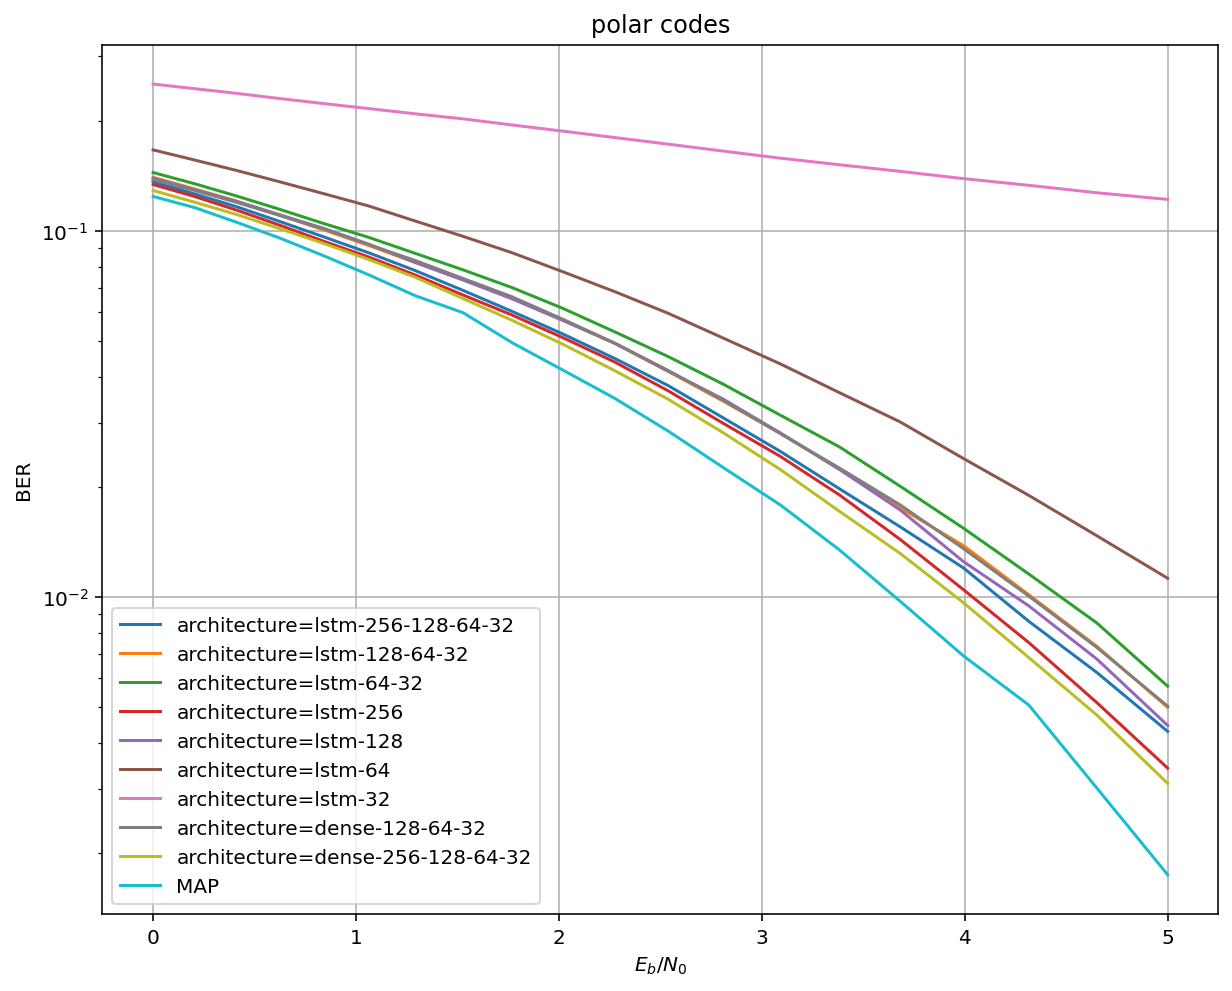

<Figure size 432x288 with 0 Axes>

In [22]:
legend = []
plt.figure(figsize=(10, 8))
for current_arch in arch:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors[arch.index(current_arch)]/nb_bits[arch.index(current_arch)])
    legend.append(f'architecture={current_arch}') 
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()


## Random codes

In [23]:
code = 'random'              # type of code ('random' or 'polar')
codewords, inputs = create_words(code)

### Train and test model

In [24]:
test_batch = 10000  
num_words = 1000000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))
sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros((len(arch),len(sigmas)),dtype=int)
nb_bits = np.zeros((len(arch),len(sigmas)),dtype=int)

In [25]:
%%time
for current_arch in arch:
    model, decoder = update_model(current_arch)
    
    print(f'fit {arch.index(current_arch)+1} of {len(arch)}')
    history = model.fit(codewords, inputs, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)


    print(f'decode {arch.index(current_arch)+1} of {len(arch)}')
    for i in range(0,len(sigmas)):

        for ii in range(0,np.round(num_words/test_batch).astype(int)):

            # Source
            np.random.seed(0)
            d_test = np.random.randint(0,2,size=(test_batch,k)) 

            # Encoder
            if code == 'polar':
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,log_vector] = d_test

                for iii in range(0,test_batch):
                    x_test[iii] = polar_transform_iter(u_test[iii])

            elif code == 'random':
                x_test = np.zeros((test_batch, N),dtype=bool)
                for iii in range(0,test_batch):
                    x_test[iii] = codewords[bin2int(d_test[iii])]

            # Modulator (BPSK)
            s_test = -2*x_test + 1

            # Channel (AWGN)
            y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

            if LLR:
                y_test = 2*y_test/(sigmas[i]**2)

            # Decoder
            nb_bits[arch.index(current_arch)][i] += d_test.size
            nb_errors[arch.index(current_arch)][i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
    
            np.savetxt(f'eval_nn_arch/{code}/bits_{code}_{N}_{k}_{arch}.out', nb_bits, delimiter=', ')
            np.savetxt(f'eval_nn_arch/{code}/errors_{code}_{N}_{k}_{arch}.out', nb_errors, delimiter=', ')

fit 1 of 9
decode 1 of 9
fit 2 of 9
decode 2 of 9
fit 3 of 9
decode 3 of 9
fit 4 of 9
decode 4 of 9
fit 5 of 9
decode 5 of 9
fit 6 of 9
decode 6 of 9
fit 7 of 9
decode 7 of 9
fit 8 of 9
decode 8 of 9
fit 9 of 9
decode 9 of 9
CPU times: user 1h 51min 4s, sys: 12min 53s, total: 2h 3min 58s
Wall time: 1h 30min 51s


### Load data

In [26]:
result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

nb_bits = np.loadtxt(f'eval_nn_arch/{code}/bits_{code}_{N}_{k}_{arch}.out', delimiter=', ' )
nb_errors = np.loadtxt(f'eval_nn_arch/{code}/errors_{code}_{N}_{k}_{arch}.out', delimiter=', ' )

### Plot Bit-Error-Rate

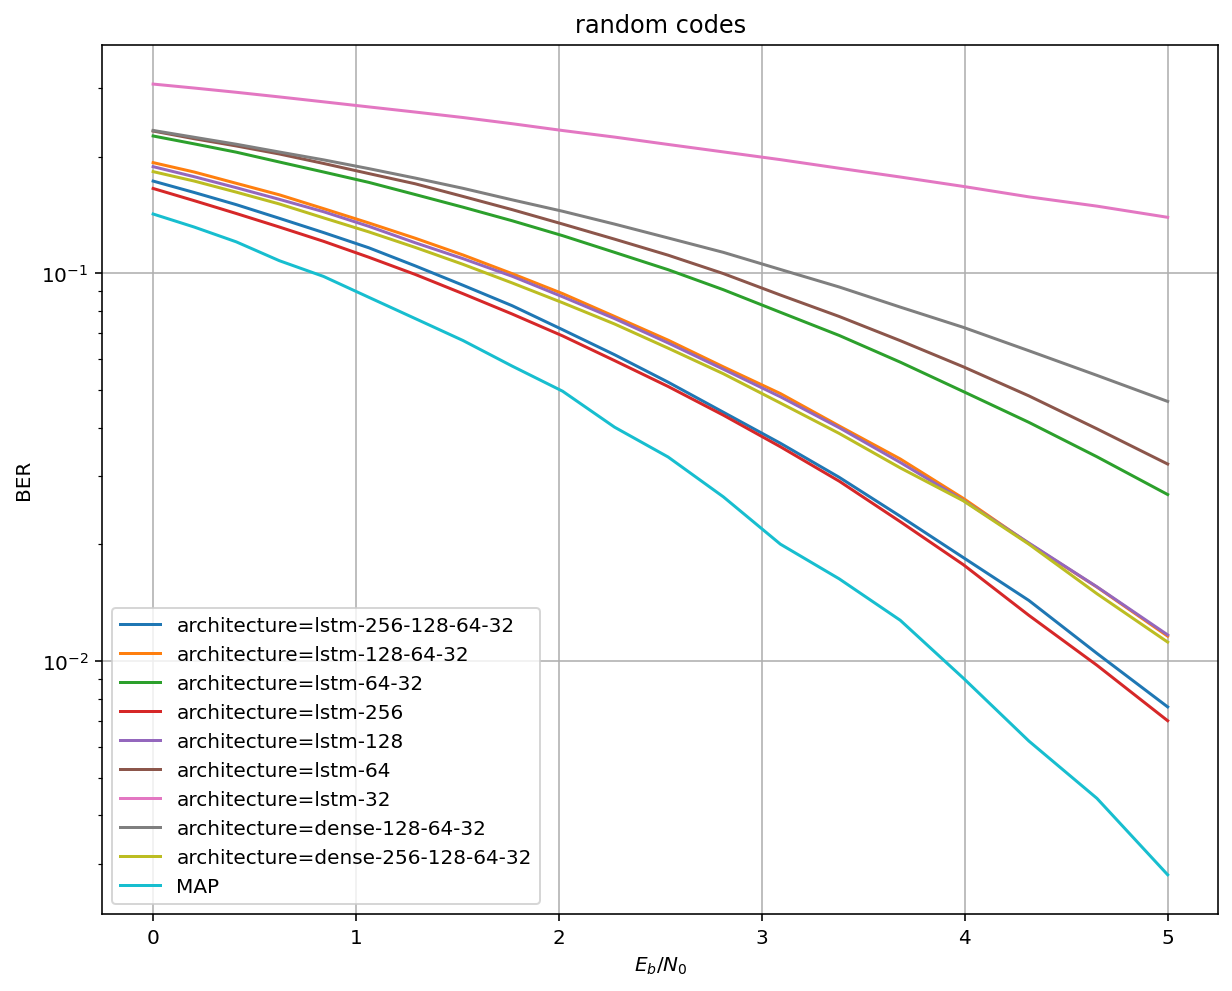

In [27]:
legend = []
plt.figure(figsize=(10, 8))
for current_arch in arch:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors[arch.index(current_arch)]/nb_bits[arch.index(current_arch)])
    legend.append(f'architecture={current_arch}') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()